# Failed Banks Information Assistant

## Objective

This notebook demonstrates the following:

- Using Assistant tools Code Interpreter and Function calling, this bot can get a CSV file, gather a list of failed banks by state, and generate a chart to visually represent the data.

This tutorial uses the following Azure AI services:
- Access to Azure OpenAI Service - you can apply for access [here](https://aka.ms/oai/access)
- Azure OpenAI service - you can create it from instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource)
- Azure OpenAI Studio - go to [https://oai.azure.com/](https://oai.azure.com/) to work with the Assistants API Playground
- A connection to the Azure OpenAI Service with a [Key and Endpoint](https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart)

Reference:
- Learn more about how to use Assistants with our [How-to guide on Assistants](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant).
- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview)


## Time

You should expect to spend 5-10 minutes running this sample. 

## About this example

This sample demonstrates the creation of an Azure OpenAI Assistant named "Failed Banks Assistant" through the Azure OpenAI API. The assistant is tailored to aid users in retrieving information about failed banks from a CSV file, the assistant efficiently processes user messages, interacts with the designated file, and promptly delivers pertinent information in response.

### Data
This sample uses files from the folder [`data/`](./data/) in this repo. You can clone this repo or copy this folder to make sure you have access to these files when running the sample.

## Before you begin



### Installation

Install the following packages required to execute this notebook. 



In [ ]:
# Install the packages
# %pip install -r ../requirements.txt

### Parameters

In [41]:
import os

from dotenv import load_dotenv

load_dotenv()

api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

should_cleanup: bool = False

In [42]:
api_deployment_name

'gpt-4o'

## Run this Example

### Load the required libraries

In [43]:
import io
import time
from datetime import datetime
from pathlib import Path
from typing import Iterable

from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

### Create an AzureOpenAI client

In [44]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

### Prepare the tools for function calling

In [45]:
tools_list = [
    {"type": "code_interpreter"},
]

In [46]:
# DATA_FOLDER = "data/"


# def upload_file(client: AzureOpenAI, path: str) -> FileObject:
#     with Path(path).open("rb") as f:
#         return client.files.create(file=f, purpose="assistants")


# arr = os.listdir(DATA_FOLDER)
# assistant_files = []
# for file in arr:
#     filePath = DATA_FOLDER + file
#     assistant_files.append(upload_file(client, filePath))

# file_ids = [file.id for file in assistant_files]

In [47]:
import os
from pathlib import Path 

DATA_FOLDER = "data/"
TARGET_FILE = "failed_banks.csv"

def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")

# 파일명으로 검색하여 파일이 존재하는지 확인
filePath = os.path.join(DATA_FOLDER, TARGET_FILE)
assistant_files = []

if os.path.exists(filePath):
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

print(file_ids)


['assistant-UnQcMkyhIeFlSu8FzEeG7RFT']


In [56]:
assistant = client.beta.assistants.create(
    name="Failed Banks Assistant",
    instructions="You are an assistant that can help find information about failed banks. "
    + "Use the provided file only.",
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)

thread = client.beta.threads.create()

In [57]:
# def format_messages(messages: Iterable[MessageFile]) -> None:
#     message_list = []

#     # Get all the messages till the last user message
#     for message in messages:
#         message_list.append(message)
#         if message.role == "user":
#             break

#     # Reverse the messages to show the last user message first
#     message_list.reverse()

#     # Print the user or Assistant messages or images
#     for message in message_list:
#         for item in message.content:
#             # Determine the content type
#             if isinstance(item, MessageContentText):
#                 print(f"{message.role}:\n{item.text.value}\n")
#             elif isinstance(item, MessageContentImageFile):
#                 # Retrieve image from file id
#                 response_content = client.files.content(item.image_file.file_id)
#                 data_in_bytes = response_content.read()
#                 # Convert bytes to image
#                 readable_buffer = io.BytesIO(data_in_bytes)
#                 image = Image.open(readable_buffer)
#                 # Resize image to fit in terminal
#                 width, height = image.size
#                 image = image.resize((width // 2, height // 2), Image.LANCZOS)
#                 # Display image
#                 image.show()

In [58]:
import io
from typing import Iterable
from PIL import Image
import matplotlib.pyplot as plt

def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image using matplotlib
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.show()


In [59]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + ".",
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            break
        if run.status == "cancelled":
            # Handle cancelled
            break
        if run.status == "requires_action":
            pass
        else:
            # print("in progress...",run.status)
            time.sleep(5)

### Process user requests

processing...
user:
Create a chart of failed banks by state.

assistant:
To create a chart of failed banks by state, we'll first need to load and inspect the contents of the uploaded file. This will help us understand its structure and identify the relevant columns for our analysis.

Let's begin by loading and examining the file.

assistant:
The data consists of several columns including `Bank Name`, `City`, `State`, `Cert`, `Acquiring Institution`, `Closing Date`, and `Fund`. For our purposes, we are interested in the `State` column to count the number of failed banks by state.

Let's proceed by creating a chart that shows the number of failed banks by state.

assistant:
It appears that the column name `State` includes some extra whitespace or special characters. We'll need to clean up the column names before proceeding with the analysis. Let's rename the columns and then try plotting the chart again.



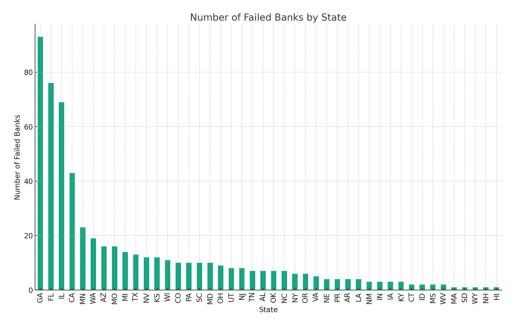

assistant:
Here is the chart showing the number of failed banks by state. 

Would you like any additional analysis or information?



In [60]:
process_message("Create a chart of failed banks by state.")

In [61]:
process_message("What was the last bank to fail?")

processing...
user:
What was the last bank to fail?

assistant:
It seems there's an extra space in the "Closing Date" column name as well. Let's clean up this column name and then find the most recent failed bank again.

assistant:
The most recent bank to fail was:

- **Bank Name:** Citizens Bank
- **City:** Sac City
- **State:** IA (Iowa)
- **Acquiring Institution:** Iowa Trust & Savings Bank
- **Closing Date:** November 3, 2023

If you need any further analysis or details, please let me know!



In [62]:
process_message("Which state has the most bank failures?")

processing...
user:
Which state has the most bank failures?

assistant:
The state with the most bank failures is Georgia (GA), with a total of 93 bank failures.

If you have any further questions or need additional analysis, please let me know!



In [63]:
process_message("Which banks failed in Florida in between 2020-2023?")

processing...
user:
Which banks failed in Florida in between 2020-2023?

assistant:
The bank that failed in Florida between 2020 and 2023 is:

- **Bank Name:** First City Bank of Florida
- **City:** Fort Walton Beach
- **Closing Date:** October 16, 2020

If you need any more information or further analysis, please let me know!



## Cleaning up


In [64]:
if should_cleanup:
    client.beta.assistants.delete(assistant.id)
    client.beta.threads.delete(thread.id)
    for file in assistant_files:
        client.files.delete(file.id)